In [1]:
import os
import math
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer

from numpy import load

from xgboost import XGBClassifier

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rd_seed = 333

# Načtení dat

In [2]:
path_file = os.sep.join(['created_data', 'matrix_semestr_2.csv'])
matrix_bak = pd.read_csv(path_file, sep=",")

# Info o datasetu

In [3]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   studium_id               2429 non-null   int64  
 1   dokoncil_semestr         2429 non-null   float64
 2   BI-PA1_znamka            2429 non-null   float64
 3   BI-PA1_poradi_zapisu     2429 non-null   float64
 4   BI-PAI_znamka            2429 non-null   float64
 5   BI-PAI_poradi_zapisu     2429 non-null   float64
 6   BI-CAO_znamka            2429 non-null   float64
 7   BI-CAO_poradi_zapisu     2429 non-null   float64
 8   BI-PS1_znamka            2429 non-null   float64
 9   BI-PS1_poradi_zapisu     2429 non-null   float64
 10  BI-MLO_znamka            2429 non-null   float64
 11  BI-MLO_poradi_zapisu     2429 non-null   float64
 12  BI-ZMA_znamka            2429 non-null   float64
 13  BI-ZMA_poradi_zapisu     2429 non-null   float64
 14  pocet_kreditu_semestr_1 

In [4]:
matrix_bak.mean()

studium_id                 1.504802e+07
dokoncil_semestr           8.435570e-01
BI-PA1_znamka              2.634006e+00
BI-PA1_poradi_zapisu       9.995883e-01
BI-PAI_znamka              2.217373e+00
BI-PAI_poradi_zapisu       9.979415e-01
BI-CAO_znamka              1.264718e+00
BI-CAO_poradi_zapisu       1.000412e+00
BI-PS1_znamka              2.483944e+00
BI-PS1_poradi_zapisu       1.000412e+00
BI-MLO_znamka              2.325854e+00
BI-MLO_poradi_zapisu       9.995883e-01
BI-ZMA_znamka              2.617950e+00
BI-ZMA_poradi_zapisu       9.991766e-01
pocet_kreditu_semestr_1    2.466900e+01
dtype: float64

# Příprava datasetu

## Nastavení indexu

In [5]:
matrix_bak = matrix_bak.set_index(['studium_id'])

## Nastavení atributů na kategorické - ordinální

In [6]:
# ordinální
grades_category = pd.api.types.CategoricalDtype(categories=[-1, 1, 1.5, 2, 2.5, 3, 4], ordered=True)
# BI-PA1
matrix_bak['BI-PA1_znamka'] = matrix_bak['BI-PA1_znamka'].astype(grades_category)
# BI-PAI
matrix_bak['BI-PAI_znamka'] = matrix_bak['BI-PAI_znamka'].astype(grades_category)
# BI-CAO
matrix_bak['BI-CAO_znamka'] = matrix_bak['BI-CAO_znamka'].astype(grades_category)
# BI-PS1
matrix_bak['BI-PS1_znamka'] = matrix_bak['BI-PS1_znamka'].astype(grades_category)
# BI-MLO
matrix_bak['BI-MLO_znamka'] = matrix_bak['BI-MLO_znamka'].astype(grades_category)
# BI-ZMA
matrix_bak['BI-ZMA_znamka'] = matrix_bak['BI-ZMA_znamka'].astype(grades_category)

In [7]:
matrix_bak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2429 entries, 14267106 to 11740806
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   dokoncil_semestr         2429 non-null   float64 
 1   BI-PA1_znamka            2429 non-null   category
 2   BI-PA1_poradi_zapisu     2429 non-null   float64 
 3   BI-PAI_znamka            2429 non-null   category
 4   BI-PAI_poradi_zapisu     2429 non-null   float64 
 5   BI-CAO_znamka            2429 non-null   category
 6   BI-CAO_poradi_zapisu     2429 non-null   float64 
 7   BI-PS1_znamka            2429 non-null   category
 8   BI-PS1_poradi_zapisu     2429 non-null   float64 
 9   BI-MLO_znamka            2429 non-null   category
 10  BI-MLO_poradi_zapisu     2429 non-null   float64 
 11  BI-ZMA_znamka            2429 non-null   category
 12  BI-ZMA_poradi_zapisu     2429 non-null   float64 
 13  pocet_kreditu_semestr_1  2429 non-null   float64 
dt

# Modelování

## Rozdělení datasetu

In [8]:
Xdata = matrix_bak.drop(columns='dokoncil_semestr')
ydata = matrix_bak.dokoncil_semestr

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.2, random_state=rd_seed, stratify=ydata, shuffle=True) 
print()
print("původní data")
display(Xdata.shape)
display(ydata.shape)
print()
print("rozložení hodnot")
display(ydata.value_counts())
display(ytrain.value_counts(normalize=True))
print()
print("trénovací data")
display(Xtrain.shape)
display(ytrain.shape)
print()
print("rozložení hodnot")
display(ytrain.value_counts())
display(ytrain.value_counts(normalize=True))
print()
print("testovací data")
display(Xtest.shape)
display(ytest.shape)
print()
print("rozložení hodnot")
display(ytest.value_counts())
display(ytest.value_counts(normalize=True))


původní data


(2429, 13)

(2429,)


rozložení hodnot


1.0    2049
0.0     380
Name: dokoncil_semestr, dtype: int64

1.0    0.843541
0.0    0.156459
Name: dokoncil_semestr, dtype: float64


trénovací data


(1943, 13)

(1943,)


rozložení hodnot


1.0    1639
0.0     304
Name: dokoncil_semestr, dtype: int64

1.0    0.843541
0.0    0.156459
Name: dokoncil_semestr, dtype: float64


testovací data


(486, 13)

(486,)


rozložení hodnot


1.0    410
0.0     76
Name: dokoncil_semestr, dtype: int64

1.0    0.843621
0.0    0.156379
Name: dokoncil_semestr, dtype: float64

## Funkce pro vybrání vhodných hyperparametrů pomocí křížové validace

In [10]:
def get_best_parameters(param_grid, classifier, xgb=None):
    score = 'f1'
    if xgb:
        model = GridSearchCV(classifier(eval_metric='mlogloss', use_label_encoder=False, tree_method="gpu_hist", enable_categorical=True), param_grid, cv=5, scoring=score)
    else:
        model = GridSearchCV(classifier(), param_grid, cv=5, scoring=score)
    model.fit(Xtrain, ytrain)

    print('Best hyper-parameters are: ')
    print(model.best_params_)
    print()

    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    return model

## Rozhodovací strom

In [11]:
param_grid = [
    {'criterion':['gini','entropy'],
    'max_depth': range(2,7),
    'min_samples_leaf':[10]}
]

In [12]:
dt = get_best_parameters(param_grid, DecisionTreeClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}

0.921225 (+/-0.019250) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
0.920286 (+/-0.019209) for {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}
0.920891 (+/-0.013147) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}
0.917134 (+/-0.015507) for {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10}
0.914638 (+/-0.016006) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10}
0.921225 (+/-0.019250) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}
0.921916 (+/-0.018844) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10}
0.919189 (+/-0.016889) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10}
0.918128 (+/-0.015790) for {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10}
0.917390 (+/-0.016465) for {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10}



### Výsledky modelu na trénovacím a testovacím datasetu

In [13]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.862584
accuracy score (test): 0.874486


### Důležitost jednotlivých příznaků

In [14]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':dt.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
12,pocet_kreditu_semestr_1,0.943801
10,BI-ZMA_znamka,0.023288
6,BI-PS1_znamka,0.016790
0,BI-PA1_znamka,0.016120
1,BI-PA1_poradi_zapisu,0.000000
2,BI-PAI_znamka,0.000000
3,BI-PAI_poradi_zapisu,0.000000
4,BI-CAO_znamka,0.000000
5,BI-CAO_poradi_zapisu,0.000000
7,BI-PS1_poradi_zapisu,0.000000


### Vytvořený rozhodovací strom

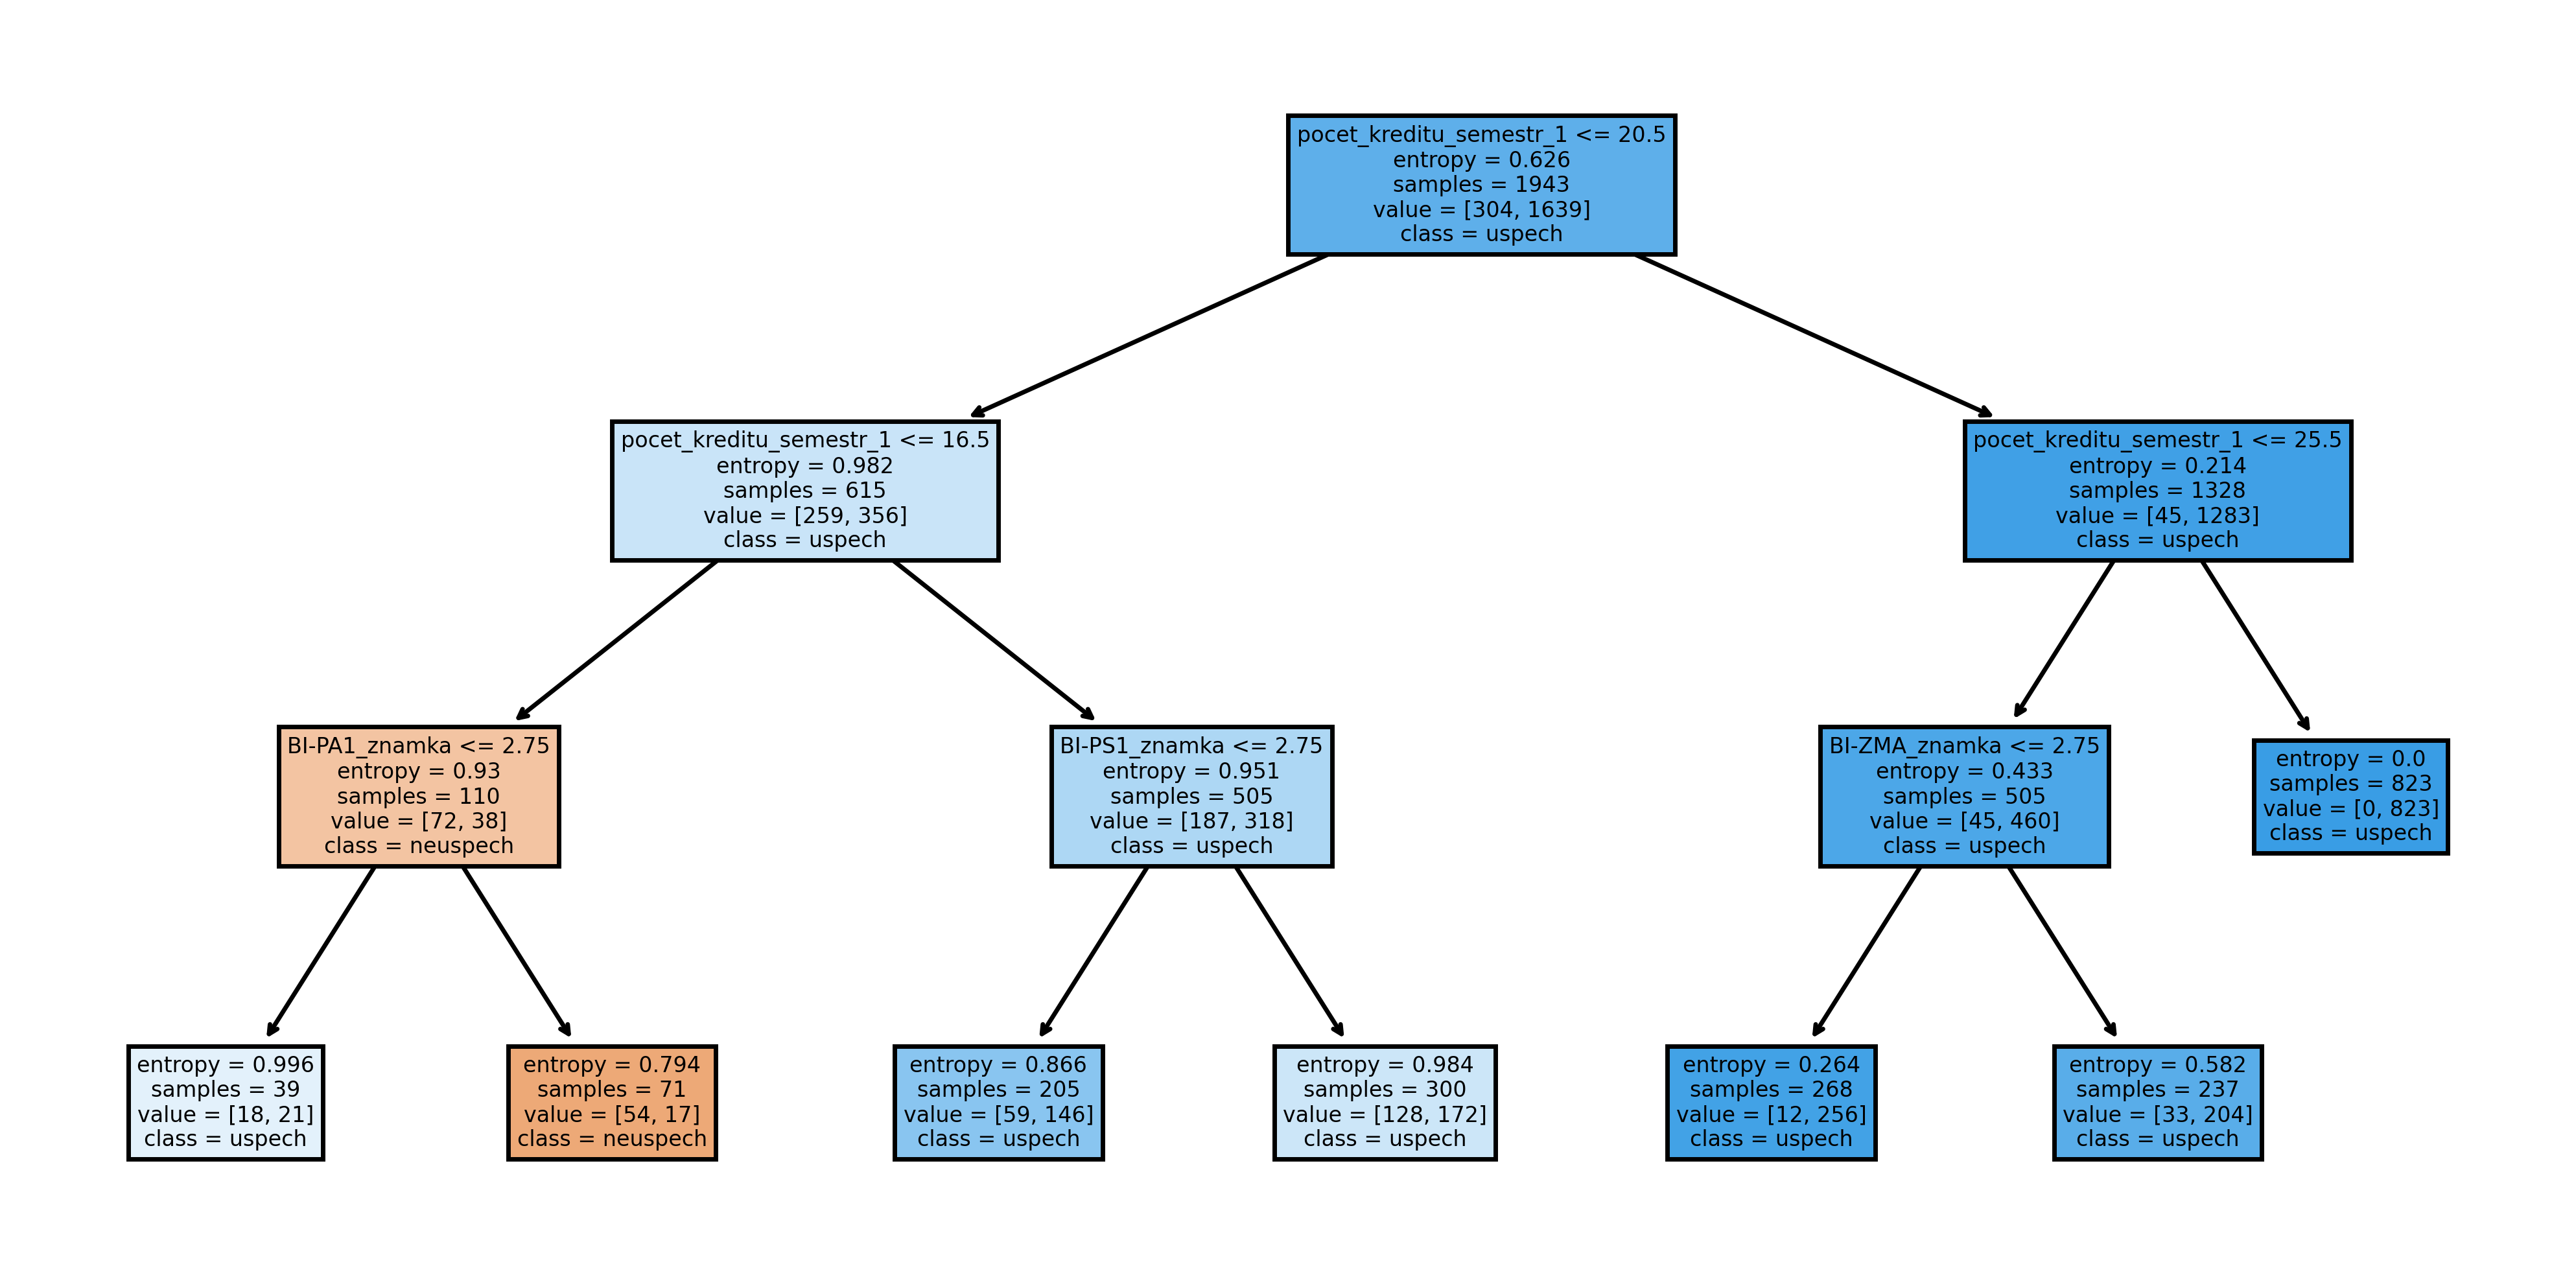

In [15]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=500)
tree.plot_tree(dt.best_estimator_,
               feature_names = Xdata.columns, 
               class_names=['neuspech', 'uspech'],
               filled = True);
path_file = os.sep.join(['decision_trees', 'tree_f1_semestr2.png'])
fig.savefig(path_file)

## Random forest

In [16]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'n_estimators': range(5, 50, 5),
    'max_depth': range(2, 4),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf':[10]
}

In [17]:
rf = get_best_parameters(param_grid_rf, RandomForestClassifier)

Best hyper-parameters are: 
{'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 5}

0.914378 (+/-0.002575) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 5}
0.914828 (+/-0.001776) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
0.915901 (+/-0.002399) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 15}
0.915131 (+/-0.001086) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20}
0.915131 (+/-0.001086) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 25}
0.915131 (+/-0.001086) for {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30}
0.915131 (+/-0.001086) for {'criterion': 'gini', 'max_depth': 2, 'ma

### Výsledky modelu na trénovacím a testovacím datasetu

In [18]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, rf.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, rf.predict(Xtest))))

accuracy score (train): 0.863613
accuracy score (test): 0.876543


### Důležitost jednotlivých příznaků

In [19]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':rf.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
12,pocet_kreditu_semestr_1,0.940193
0,BI-PA1_znamka,0.020042
10,BI-ZMA_znamka,0.019873
6,BI-PS1_znamka,0.014438
4,BI-CAO_znamka,0.005454
1,BI-PA1_poradi_zapisu,0.000000
2,BI-PAI_znamka,0.000000
3,BI-PAI_poradi_zapisu,0.000000
5,BI-CAO_poradi_zapisu,0.000000
7,BI-PS1_poradi_zapisu,0.000000


## Adaboost

In [20]:
param_grid_ab = {
    'n_estimators': range(5, 50, 5),
    'learning_rate': np.arange(0.1, 1., 0.1)
}

In [21]:
ab = get_best_parameters(param_grid_ab, AdaBoostClassifier)

Best hyper-parameters are: 
{'learning_rate': 0.5, 'n_estimators': 5}

0.915131 (+/-0.001086) for {'learning_rate': 0.1, 'n_estimators': 5}
0.913271 (+/-0.007947) for {'learning_rate': 0.1, 'n_estimators': 10}
0.915914 (+/-0.011166) for {'learning_rate': 0.1, 'n_estimators': 15}
0.917189 (+/-0.013201) for {'learning_rate': 0.1, 'n_estimators': 20}
0.916606 (+/-0.012546) for {'learning_rate': 0.1, 'n_estimators': 25}
0.917834 (+/-0.015027) for {'learning_rate': 0.1, 'n_estimators': 30}
0.919122 (+/-0.014914) for {'learning_rate': 0.1, 'n_estimators': 35}
0.919032 (+/-0.016134) for {'learning_rate': 0.1, 'n_estimators': 40}
0.921126 (+/-0.021794) for {'learning_rate': 0.1, 'n_estimators': 45}
0.915131 (+/-0.001086) for {'learning_rate': 0.2, 'n_estimators': 5}
0.917453 (+/-0.013439) for {'learning_rate': 0.2, 'n_estimators': 10}
0.918213 (+/-0.012619) for {'learning_rate': 0.2, 'n_estimators': 15}
0.920817 (+/-0.021592) for {'learning_rate': 0.2, 'n_estimators': 20}
0.921442 (+/-0.021816

### Výsledky modelu na trénovacím a testovacím datasetu

In [22]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, ab.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, ab.predict(Xtest))))

accuracy score (train): 0.864128
accuracy score (test): 0.866255


### Důležitost jednotlivých příznaků

In [23]:
feature_importances=pd.DataFrame({'features':Xtrain.columns,'feature_importance':ab.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
12,pocet_kreditu_semestr_1,0.8
4,BI-CAO_znamka,0.2
0,BI-PA1_znamka,0.0
1,BI-PA1_poradi_zapisu,0.0
2,BI-PAI_znamka,0.0
3,BI-PAI_poradi_zapisu,0.0
5,BI-CAO_poradi_zapisu,0.0
6,BI-PS1_znamka,0.0
7,BI-PS1_poradi_zapisu,0.0
8,BI-MLO_znamka,0.0


## Xgboost

In [24]:
param_grid = {
    'eta': np.arange(0.1, 1., 0.1),
    'max_depth': range(3, 8)
}
param_comb = ParameterGrid(param_grid)

In [25]:
xgb = get_best_parameters(param_grid, XGBClassifier, True)

Best hyper-parameters are: 
{'eta': 0.1, 'max_depth': 3}

0.919799 (+/-0.023003) for {'eta': 0.1, 'max_depth': 3}
0.916985 (+/-0.017830) for {'eta': 0.1, 'max_depth': 4}
0.914957 (+/-0.019673) for {'eta': 0.1, 'max_depth': 5}
0.910780 (+/-0.016148) for {'eta': 0.1, 'max_depth': 6}
0.909778 (+/-0.020925) for {'eta': 0.1, 'max_depth': 7}
0.916055 (+/-0.020116) for {'eta': 0.2, 'max_depth': 3}
0.911982 (+/-0.014766) for {'eta': 0.2, 'max_depth': 4}
0.908802 (+/-0.014359) for {'eta': 0.2, 'max_depth': 5}
0.907625 (+/-0.021615) for {'eta': 0.2, 'max_depth': 6}
0.903820 (+/-0.016786) for {'eta': 0.2, 'max_depth': 7}
0.909973 (+/-0.018195) for {'eta': 0.30000000000000004, 'max_depth': 3}
0.907540 (+/-0.015353) for {'eta': 0.30000000000000004, 'max_depth': 4}
0.905684 (+/-0.020800) for {'eta': 0.30000000000000004, 'max_depth': 5}
0.906090 (+/-0.018132) for {'eta': 0.30000000000000004, 'max_depth': 6}
0.900369 (+/-0.017874) for {'eta': 0.30000000000000004, 'max_depth': 7}
0.909693 (+/-0.020629)

### Výsledky modelu na trénovacím a testovacím datasetu

In [26]:
print('accuracy score XGBoost (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, xgb.predict(Xtrain))))
print('accuracy score XGBoost (test): {0:.6f}'.format(metrics.accuracy_score(ytest, xgb.predict(Xtest))))

accuracy score XGBoost (train): 0.883170
accuracy score XGBoost (test): 0.862140


### Důležitost jednotlivých příznaků

In [27]:
feat_imp = pd.Series(xgb.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)

In [28]:
feat_imp

pocet_kreditu_semestr_1    153.0
BI-PA1_znamka               68.0
BI-PS1_znamka               66.0
BI-PAI_znamka               61.0
BI-ZMA_znamka               56.0
BI-CAO_znamka               47.0
BI-MLO_znamka               36.0
dtype: float64

## MLP

In [29]:
mlp = MLPClassifier(random_state=1, max_iter=500).fit(Xtrain, ytrain)

### Výsledky modelu na trénovacím a testovacím datasetu

In [30]:
print('accuracy score mlp (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, mlp.predict(Xtrain))))
print('accuracy score mlp (test): {0:.6f}'.format(metrics.accuracy_score(ytest, mlp.predict(Xtest))))

accuracy score mlp (train): 0.867730
accuracy score mlp (test): 0.872428


## kNN

In [31]:
param_grid = {
    'n_neighbors' : range(1, 12), # Počet nejbližších sousedů
    'p': range(1, 3), # Stupeň Minkowského vzdálenosti
    'weights': ['uniform', 'distance'], # Aritmetický, nebo vážený průměr
}
param_comb = ParameterGrid(param_grid)

In [32]:
knn = get_best_parameters(param_grid, KNeighborsClassifier)

Best hyper-parameters are: 
{'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

0.891751 (+/-0.009660) for {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.891751 (+/-0.009660) for {'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.890547 (+/-0.010363) for {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.890547 (+/-0.010363) for {'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.871984 (+/-0.020621) for {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.877136 (+/-0.017522) for {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.872617 (+/-0.010734) for {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.879149 (+/-0.011815) for {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.903068 (+/-0.018543) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.895032 (+/-0.013783) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.903775 (+/-0.015861) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.898234 (+/-0.013369) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.8

### Výsledky modelu na trénovacím a testovacím datasetu

In [33]:
print('accuracy score knn (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, knn.predict(Xtrain))))
print('accuracy score knn (test): {0:.6f}'.format(metrics.accuracy_score(ytest, knn.predict(Xtest))))

accuracy score knn (train): 0.881626
accuracy score knn (test): 0.849794


# Výsledky

In [34]:
results = pd.DataFrame(columns=['vysledky'], index=['dt', 'rf', 'ab', 'xgb', 'mlp', 'knn'])

In [35]:
results.loc['dt', 'vysledky'] = round(metrics.accuracy_score(ytest, dt.predict(Xtest)), 3)
results.loc['rf', 'vysledky'] = round(metrics.accuracy_score(ytest, rf.predict(Xtest)), 3)
results.loc['ab', 'vysledky'] = round(metrics.accuracy_score(ytest, ab.predict(Xtest)), 3)
results.loc['xgb', 'vysledky'] = round(metrics.accuracy_score(ytest, xgb.predict(Xtest)), 3)
results.loc['mlp', 'vysledky'] = round(metrics.accuracy_score(ytest, mlp.predict(Xtest)), 3)
results.loc['knn', 'vysledky'] = round(metrics.accuracy_score(ytest, knn.predict(Xtest)), 3)

### Výsledky zobrazené grafem

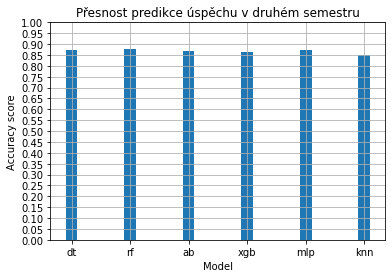

In [36]:
fig, ax = plt.subplots()
width = 0.2
ax.bar(results.index, results['vysledky'].values, width)

ax.set_ylabel('Accuracy score')
ax.set_xlabel('Model')
ax.set_title('Přesnost predikce úspěchu v druhém semestru')

ax.grid(True)
y_values = np.arange(0.0, 1.05, 0.05)
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.yticks(y_values)
plt.show()

### Výsledky zobrazené tabulkou

In [37]:
results

,vysledky
dt,0.874
rf,0.877
ab,0.866
xgb,0.862
mlp,0.872
knn,0.85
